# 🚀 GPT2: Autoregressive to Diffusion with Attention Annealing + Shift Operation

## 📋 概述

本 notebook 综合实现了两种关键技术，将 GPT2 从 autoregressive 模型转换为 diffusion 模型：

### 核心技术：
1. **Attention Mask Annealing（注意力退火）**
   - 从因果掩码（causal mask）逐渐过渡到双向注意力
   - 训练过程中动态调整 attention mask
   - 使模型能够利用完整的上下文信息

2. **Shift Operation（位移操作）**
   - 在计算 diffusion loss 时对 target 进行位移
   - 提升训练效率和收敛速度
   - 论文中验证的关键技术

### 参考论文：
*Scaling Diffusion Language Models via Adaptation from Autoregressive Models* (ICLR 2025)

---

## 1️⃣ 环境配置

In [1]:
# 禁用 tokenizers 多进程警告
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

import torch
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ 显存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✓ PyTorch: 2.7.0+cu128
✓ CUDA: True
✓ GPU: NVIDIA GeForce RTX 5090
✓ 显存: 33.7 GB


## 2️⃣ 导入依赖库

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from modelscope import GPT2Tokenizer, GPT2Model
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from dataclasses import dataclass
import time
import json
from pathlib import Path

print("✓ 所有库导入成功")

✓ 所有库导入成功


## 3️⃣ 配置参数

In [3]:
@dataclass
class CombinedConfig:
    """
    正式训练配置 - Full Training Configuration
    
    ⚠️ 重要修改：
    1. max_train_samples = None  # 使用全部数据
    2. max_length = 512  # 增加序列长度
    3. num_epochs = 10  # 增加训练轮数
    4. anneal_steps = 10000  # 增加annealing步数
    5. use_amp = True  # 启用混合精度
    """
    
    # ========== 模型配置 ==========
    model_name: str = "gpt2"  # 可选: "gpt2" (117M), "gpt2-medium" (345M), "gpt2-large" (774M)
    
    # ========== 数据配置 ========== ⚠️ 关键修改
    data_path: str = "./autodl-tmp/arxiv_train-1.jsonl"  # 训练数据路径（.txt 或 .jsonl）
    max_length: int = 512  # ⭐ 从128增加到512（根据GPU内存调整）
    max_train_samples: int = None  # ⭐ 从demo的5000改为None（使用全部数据）
    
    # ========== 训练参数 ========== ⚠️ 根据GPU调整
    batch_size: int = 8  # ⭐ 从4增加到8（16GB GPU适用）
    gradient_accumulation_steps: int = 4  # ⭐ 从2增加到4
    # 有效batch size = 8 × 4 = 32
    
    num_epochs: int = 10  # ⭐ 从3增加到10（根据数据量调整）
    learning_rate: float = 5e-5  # 学习率（保持不变）
    warmup_steps: int = 1000  # ⭐ 从100增加到1000（约10%总步数）
    max_grad_norm: float = 1.0  # 梯度裁剪
    
    # ========== Attention Annealing 参数 ========== ⚠️ 非常重要
    anneal_steps: int = 10000  # ⭐ 从1000增加到10000（约30-50%总步数）
    start_anneal_ratio: float = 0.0  # 初始：完全因果注意力
    end_anneal_ratio: float = 1.0    # 最终：完全双向注意力
    
    # ========== Shift Operation ========== ⚠️ 必须启用
    use_shift: bool = True  # ⭐ 论文的关键操作，不要改
    
    # ========== Diffusion 参数 ==========
    min_t: float = 0.01  # 最小时间步
    max_t: float = 0.99  # 最大时间步
    
    # ========== 设备和优化 ==========
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    use_amp: bool = True  # ⭐ 从False改为True（启用混合精度，加速1.5-2倍）
    
    # ========== 输出和保存 ==========
    output_dir: str = "./outputs/gpt2_diffusion_full"  # ⭐ 改为新的输出目录
    save_steps: int = 2000  # ⭐ 从500增加到2000（降低I/O开销）
    log_steps: int = 100  # ⭐ 从50增加到100

config = CombinedConfig()
os.makedirs(config.output_dir, exist_ok=True)

# 计算一些关键指标
effective_batch_size = config.batch_size * config.gradient_accumulation_steps

print("\n" + "="*60)
print("🚀 正式训练配置")
print("="*60)
print(f"\n💻 模型配置:")
print(f"  - 模型: {config.model_name}")
print(f"  - 设备: {config.device}")
print(f"  - 混合精度: {'✓ 启用' if config.use_amp else '✗ 禁用'}")

print(f"\n📁 数据配置:")
print(f"  - 数据路径: {config.data_path}")
print(f"  - 序列长度: {config.max_length}")
print(f"  - 训练样本: {'ALL (全部)' if config.max_train_samples is None else config.max_train_samples}")

print(f"\n🎯 训练参数:")
print(f"  - Batch Size: {config.batch_size}")
print(f"  - Gradient Accumulation: {config.gradient_accumulation_steps}")
print(f"  - 有效 Batch Size: {effective_batch_size}")
print(f"  - Epochs: {config.num_epochs}")
print(f"  - Learning Rate: {config.learning_rate}")
print(f"  - Warmup Steps: {config.warmup_steps}")

print(f"\n⭐ Diffusion 特有配置:")
print(f"  - Attention Annealing: {config.anneal_steps} 步")
print(f"  - Shift Operation: {'✓ 启用' if config.use_shift else '✗ 禁用'}")

print(f"\n💾 输出配置:")
print(f"  - 输出目录: {config.output_dir}")
print(f"  - 保存频率: 每 {config.save_steps} 步")
print(f"  - 日志频率: 每 {config.log_steps} 步")

print(f"\n" + "="*60)
print("⚠️  请确认数据文件存在: {config.data_path}")
print("="*60 + "\n")


🚀 正式训练配置

💻 模型配置:
  - 模型: gpt2
  - 设备: cuda
  - 混合精度: ✓ 启用

📁 数据配置:
  - 数据路径: ./autodl-tmp/arxiv_train-1.jsonl
  - 序列长度: 512
  - 训练样本: ALL (全部)

🎯 训练参数:
  - Batch Size: 8
  - Gradient Accumulation: 4
  - 有效 Batch Size: 32
  - Epochs: 10
  - Learning Rate: 5e-05
  - Warmup Steps: 1000

⭐ Diffusion 特有配置:
  - Attention Annealing: 10000 步
  - Shift Operation: ✓ 启用

💾 输出配置:
  - 输出目录: ./outputs/gpt2_diffusion_full
  - 保存频率: 每 2000 步
  - 日志频率: 每 100 步

⚠️  请确认数据文件存在: {config.data_path}



## 4️⃣ Attention Mask Annealing 函数

实现注意力掩码的退火机制，从因果掩码逐渐过渡到双向注意力。

✓ Attention Annealing 函数定义完成


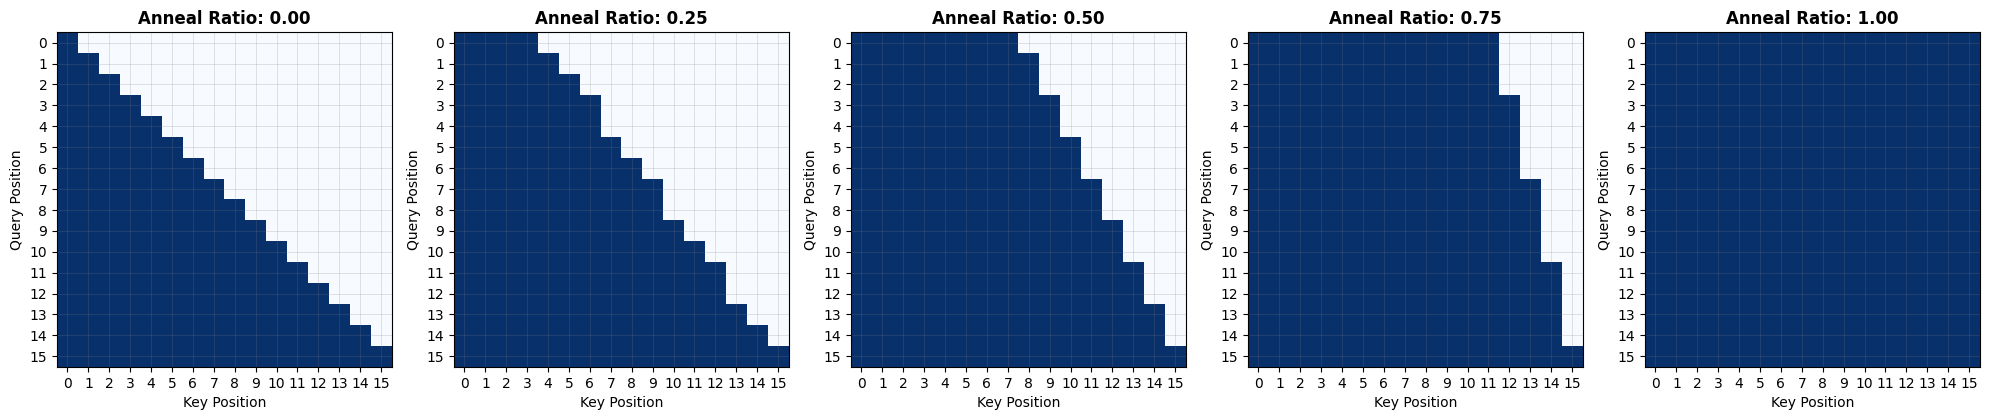

In [4]:
def create_attention_mask_with_annealing(seq_length, anneal_ratio, device):
    """
    创建带有退火的注意力掩码
    
    Args:
        seq_length: 序列长度
        anneal_ratio: 退火比例 (0.0 = 完全因果, 1.0 = 完全双向)
        device: 设备
    
    Returns:
        attention_mask: [seq_length, seq_length] 的掩码矩阵
    """
    # 创建基础的因果掩码 (下三角矩阵)
    causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=device))
    
    if anneal_ratio >= 1.0:
        # 完全双向
        return torch.ones(seq_length, seq_length, device=device)
    elif anneal_ratio <= 0.0:
        # 完全因果
        return causal_mask
    
    # 计算每个位置可以看到右边多少个 tokens
    mask = causal_mask.clone()
    
    for i in range(seq_length):
        # 计算这个位置可以额外看到右边多少个 tokens
        right_context = int((seq_length - i - 1) * anneal_ratio)
        if right_context > 0:
            mask[i, i+1:i+1+right_context] = 1.0
    
    return mask


def visualize_attention_masks(seq_length=16, save_path=None):
    """可视化不同退火阶段的注意力掩码"""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    for ax, ratio in zip(axes, ratios):
        mask = create_attention_mask_with_annealing(seq_length, ratio, 'cpu')
        ax.imshow(mask.numpy(), cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'Anneal Ratio: {ratio:.2f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        # 添加网格
        ax.set_xticks(np.arange(seq_length))
        ax.set_yticks(np.arange(seq_length))
        ax.grid(which='both', color='gray', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


print("✓ Attention Annealing 函数定义完成")

# 可视化注意力掩码
visualize_attention_masks(
    seq_length=16, 
    save_path=os.path.join(config.output_dir, 'attention_masks.png')
)

## 5️⃣ Diffusion 核心函数（带 Shift Operation）

实现 diffusion 的前向过程和损失计算，包含 shift operation。

In [5]:
def forward_diffusion_step(x0, t, mask_token_id, device):
    """
    前向 diffusion 过程：对输入序列进行随机 mask
    
    Args:
        x0: [batch_size, seq_length] 原始 token ids
        t: [batch_size] 时间步（mask 概率），范围 [0, 1]
        mask_token_id: mask token 的 id
        device: 设备
    
    Returns:
        xt: [batch_size, seq_length] masked 序列
        mask: [batch_size, seq_length] mask 位置（True 表示被 mask）
    """
    batch_size, seq_len = x0.shape
    
    # 扩展 mask 概率到序列维度
    mask_prob = t.unsqueeze(1).expand(-1, seq_len)
    
    # 生成随机 mask
    random_values = torch.rand(batch_size, seq_len, device=device)
    mask = random_values < mask_prob
    
    # 应用 mask
    xt = x0.clone()
    xt[mask] = mask_token_id
    
    return xt, mask


def compute_diffusion_loss_with_shift(logits, x0, mask, t):
    """
    计算带 SHIFT OPERATION 的 diffusion loss
    
    Args:
        logits: [batch_size, seq_length, vocab_size] 模型输出
        x0: [batch_size, seq_length] 原始 tokens
        mask: [batch_size, seq_length] mask 位置
        t: [batch_size] 时间步
    
    Returns:
        loss: 标量 loss
    """
    # 处理 NaN 和 Inf
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
    
    batch_size, seq_len, vocab_size = logits.shape
    
    # 🔑 关键：SHIFT targets
    # 论文中的 shift operation：预测下一个 token 而不是当前 token
    shifted_targets = torch.cat([
        x0[:, 1:],
        torch.zeros(batch_size, 1, dtype=x0.dtype, device=x0.device)
    ], dim=1)
    
    shifted_mask = torch.cat([
        mask[:, 1:],
        torch.zeros(batch_size, 1, dtype=mask.dtype, device=mask.device)
    ], dim=1)
    
    # 计算交叉熵 loss
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = shifted_targets.reshape(-1)
    mask_flat = shifted_mask.reshape(-1)
    
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
    ce_loss = ce_loss * mask_flat.float()
    
    # 检查 NaN
    if torch.isnan(ce_loss).any() or torch.isinf(ce_loss).any():
        return torch.tensor(0.0, device=logits.device)
    
    # 时间加权（重要：给不同时间步不同的权重）
    if mask_flat.sum() > 0:
        t_expanded = t.unsqueeze(1).expand(-1, seq_len).reshape(-1)
        weights = 1.0 / (t_expanded[mask_flat] + 1e-8)
        weighted_loss = ce_loss[mask_flat] * weights
        return weighted_loss.mean()
    else:
        return ce_loss.mean()


def compute_diffusion_loss_without_shift(logits, x0, mask, t):
    """
    计算不带 SHIFT 的 diffusion loss（baseline）
    
    Args:
        logits: [batch_size, seq_length, vocab_size] 模型输出
        x0: [batch_size, seq_length] 原始 tokens
        mask: [batch_size, seq_length] mask 位置
        t: [batch_size] 时间步
    
    Returns:
        loss: 标量 loss
    """
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)
    
    batch_size, seq_len, vocab_size = logits.shape
    
    # 不 shift，直接对齐
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = x0.reshape(-1)
    mask_flat = mask.reshape(-1)
    
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
    ce_loss = ce_loss * mask_flat.float()
    
    if torch.isnan(ce_loss).any() or torch.isinf(ce_loss).any():
        return torch.tensor(0.0, device=logits.device)
    
    if mask_flat.sum() > 0:
        t_expanded = t.unsqueeze(1).expand(-1, seq_len).reshape(-1)
        weights = 1.0 / (t_expanded[mask_flat] + 1e-8)
        weighted_loss = ce_loss[mask_flat] * weights
        return weighted_loss.mean()
    else:
        return ce_loss.mean()


print("✓ Diffusion 核心函数定义完成")
print(f"  - Shift Operation: {'✓ 启用' if config.use_shift else '✗ 禁用'}")

✓ Diffusion 核心函数定义完成
  - Shift Operation: ✓ 启用


## 6️⃣ GPT2 模型包装器（支持 Attention Annealing）

In [6]:
class GPT2WithAnnealingAndDiffusion(nn.Module):
    """
    支持 Attention Annealing 和 Diffusion 训练的 GPT2 模型
    
    🔧 完全修复版：解决设备不匹配问题
    """
    
    def __init__(self, base_model, mask_token_id):
        super().__init__()
        self.gpt2 = base_model
        self.config_gpt = base_model.config
        self.mask_token_id = mask_token_id
        
        # 获取最大序列长度
        self.max_positions = base_model.config.n_positions
        
        # 🔧 关键修复：不在 __init__ 中保存 original_biases
        # 因为此时模型可能还在 CPU 上，之后会被移到 GPU
        # 我们将在需要时动态获取
        self._original_biases_saved = False
        self.original_biases = {}
    
    def _save_original_biases_if_needed(self):
        """
        在第一次调用时保存原始 biases
        此时模型已经在正确的设备上了
        """
        if not self._original_biases_saved:
            for i, block in enumerate(self.gpt2.transformer.h):
                self.original_biases[i] = block.attn.bias.clone().detach()
            self._original_biases_saved = True
    
    def set_attention_pattern(self, anneal_ratio):
        """
        设置注意力模式
        
        Args:
            anneal_ratio: 0.0 = 完全因果，1.0 = 完全双向
        """
        # 确保已保存原始 biases
        self._save_original_biases_if_needed()
        
        # 🔧 关键修复：从当前的 block 获取设备，而不是从 original_biases
        # 因为模型可能在 __init__ 后被移到了不同的设备
        device = self.gpt2.transformer.h[0].attn.bias.device
        
        if anneal_ratio >= 1.0:
            # 完全双向 - 移除 causal mask
            new_mask = torch.ones(1, 1, self.max_positions, self.max_positions, 
                                 dtype=torch.bool, device=device)
        elif anneal_ratio <= 0.0:
            # 完全因果 - 恢复原始 mask
            for i, block in enumerate(self.gpt2.transformer.h):
                # 确保恢复的 mask 在正确的设备上
                block.attn.bias.data = self.original_biases[i].to(device)
            return
        else:
            # 部分退火 - 基于 anneal_ratio 扩展 context
            # 🔧 关键修复：直接在正确的设备上创建 tensor
            new_mask = torch.tril(torch.ones(self.max_positions, self.max_positions, device=device))
            
            # 根据 anneal_ratio 添加右侧 context
            for i in range(self.max_positions):
                right_context = int((self.max_positions - i - 1) * anneal_ratio)
                if right_context > 0:
                    new_mask[i, i+1:min(i+1+right_context, self.max_positions)] = 1.0
            
            new_mask = new_mask.unsqueeze(0).unsqueeze(0).bool()
        
        # 更新所有 attention block 的 bias
        for block in self.gpt2.transformer.h:
            block.attn.bias.data = new_mask
    
    def forward(self, input_ids, attention_mask=None, anneal_ratio=0.0):
        """
        前向传播
        
        Args:
            input_ids: [batch_size, seq_length]
            attention_mask: [batch_size, seq_length] padding mask (可选)
            anneal_ratio: 退火比例 (0.0 = 因果, 1.0 = 双向)
        
        Returns:
            logits: [batch_size, seq_length, vocab_size]
        """
        # 设置 attention pattern
        self.set_attention_pattern(anneal_ratio)
        
        # 调用 GPT2（只传递 padding mask）
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,  # 这里只传递 padding mask
            return_dict=True
        )
        
        return outputs.logits


print("✓ GPT2 模型包装器定义完成")
print("  - 使用内部 bias 修改实现 attention annealing")
print("  - 🔧 完全修复了设备不匹配问题")
print("  - 🔧 延迟保存 original biases 直到模型在正确设备上")

✓ GPT2 模型包装器定义完成
  - 使用内部 bias 修改实现 attention annealing
  - 🔧 完全修复了设备不匹配问题
  - 🔧 延迟保存 original biases 直到模型在正确设备上


## 7️⃣ 数据集和数据加载

In [7]:
class DiffusionDataset(Dataset):
    """Diffusion 训练数据集"""
    
    def __init__(self, texts, tokenizer, max_length=128):
        """
        Args:
            texts: 文本列表
            tokenizer: tokenizer
            max_length: 最大序列长度
        """
        print(f"\n构建数据集...")
        print(f"  总样本数: {len(texts)}")
        
        self.examples = []
        print("  Tokenizing...")
        
        for text in tqdm(texts, desc="Tokenizing"):
            if len(text) > 10:  # 跳过太短的文本
                encoding = tokenizer(
                    text,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                self.examples.append({
                    'input_ids': encoding['input_ids'].squeeze(0),
                    'attention_mask': encoding['attention_mask'].squeeze(0)
                })
        
        print(f"  ✓ 有效样本: {len(self.examples)}")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        return self.examples[idx]


def load_training_data(data_path, max_samples=None):
    """
    快速加载训练数据
    
    Args:
        data_path: 数据文件路径 (.txt 或 .jsonl)
        max_samples: 最大样本数（None 表示加载全部）
    
    Returns:
        texts: 文本列表
    """
    data_path = Path(data_path)
    
    if not data_path.exists():
        # 如果文件不存在，使用示例数据
        print(f"⚠️  数据文件不存在: {data_path}")
        print("使用示例数据进行演示...")
        
        # 生成一些示例文本
        example_texts = [
            "The quick brown fox jumps over the lazy dog.",
            "Artificial intelligence is transforming the world.",
            "Machine learning models can learn from data.",
            "Deep learning has achieved remarkable success.",
            "Natural language processing enables computers to understand text.",
        ] * 200  # 重复以生成更多样本
        
        return example_texts[:max_samples] if max_samples else example_texts
    
    texts = []
    
    # 根据文件扩展名选择读取方式
    if data_path.suffix == '.txt':
        print(f"从文本文件加载: {data_path}")
        with open(data_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if max_samples and i >= max_samples:
                    break
                text = line.strip()
                if text:  # 跳过空行
                    texts.append(text)
    
    elif data_path.suffix == '.jsonl':
        print(f"从 JSONL 文件加载: {data_path}")
        with open(data_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if max_samples and i >= max_samples:
                    break
                data = json.loads(line)
                texts.append(data['text'])
    
    else:
        raise ValueError(
            f"不支持的文件格式: {data_path.suffix}，请使用 .txt 或 .jsonl"
        )
    
    return texts


print("✓ 数据集类定义完成")

✓ 数据集类定义完成


## 8️⃣ 加载模型和 Tokenizer

In [8]:
print("="*60)
print("加载模型和 Tokenizer")
print("="*60)

# 🔧 使用 modelscope 加载模型和 tokenizer
print(f"\n1. 从 modelscope 加载 {config.model_name} tokenizer...")
# 使用 modelscope 的格式：'openai-community/gpt2'
model_path = f'openai-community/{config.model_name}'
print(f"   模型路径: {model_path}")

tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# 设置 special tokens
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"   ✓ 设置 pad_token 为 eos_token: {tokenizer.eos_token}")

if tokenizer.mask_token is None:
    tokenizer.add_special_tokens({'mask_token': '[MASK]'})
    print("   ✓ 添加 mask token: [MASK]")

mask_token_id = tokenizer.mask_token_id
print(f"   Mask token ID: {mask_token_id}")
print(f"   Pad token ID: {tokenizer.pad_token_id}")

# 加载 GPT2 模型
print(f"\n2. 从 modelscope 加载 {config.model_name} 模型...")
base_model = GPT2Model.from_pretrained(model_path)

# 注意：modelscope 的 GPT2Model 只包含 transformer 部分，需要添加 LM head
# 我们需要手动创建 LMHead 或者使用完整的结构
print("   ⚠️  注意: modelscope 的 GPT2Model 需要手动添加 LM head")

# 方案：创建一个包装类来添加 LM head
class GPT2LMHeadModelWrapper(nn.Module):
    """为 modelscope 的 GPT2Model 添加 LM head"""
    def __init__(self, base_model, vocab_size):
        super().__init__()
        self.transformer = base_model
        self.lm_head = nn.Linear(base_model.config.n_embd, vocab_size, bias=False)
        # 绑定权重（与 transformer 的 embedding 共享）
        self.lm_head.weight = base_model.wte.weight
        self.config = base_model.config
    
    def forward(self, input_ids, attention_mask=None, return_dict=True, **kwargs):
        # 调用 transformer
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            **kwargs
        )
        hidden_states = outputs[0]
        lm_logits = self.lm_head(hidden_states)
        
        if return_dict:
            from types import SimpleNamespace
            return SimpleNamespace(logits=lm_logits)
        return (lm_logits,)
    
    def resize_token_embeddings(self, new_num_tokens):
        """调整 token embeddings 的大小"""
        old_num_tokens = self.transformer.wte.weight.shape[0]
        if new_num_tokens == old_num_tokens:
            return
        
        # 创建新的 embedding 层
        new_embeddings = nn.Embedding(new_num_tokens, self.config.n_embd)
        new_embeddings.weight.data[:old_num_tokens] = self.transformer.wte.weight.data
        self.transformer.wte = new_embeddings
        
        # 更新 lm_head
        self.lm_head = nn.Linear(self.config.n_embd, new_num_tokens, bias=False)
        self.lm_head.weight = self.transformer.wte.weight
    
    def save_pretrained(self, save_directory):
        """保存模型"""
        import os
        os.makedirs(save_directory, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))
        self.config.save_pretrained(save_directory)

# 创建带 LM head 的模型
base_model_with_head = GPT2LMHeadModelWrapper(base_model, len(tokenizer))

# 调整 embedding 层大小（如果添加了新 tokens）
if len(tokenizer) != base_model.wte.weight.shape[0]:
    base_model_with_head.resize_token_embeddings(len(tokenizer))
    print(f"   ✓ 调整词表大小: {base_model.wte.weight.shape[0]} -> {len(tokenizer)}")

# 创建包装后的模型
model = GPT2WithAnnealingAndDiffusion(base_model_with_head, mask_token_id)
model = model.to(config.device)

print(f"\n✓ 模型加载完成")
print(f"  参数量: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"  词表大小: {len(tokenizer)}")
print(f"  加载方式: modelscope")
print("="*60)

加载模型和 Tokenizer

1. 从 modelscope 加载 gpt2 tokenizer...
   模型路径: openai-community/gpt2
   ✓ 设置 pad_token 为 eos_token: <|endoftext|>
   ✓ 添加 mask token: [MASK]
   Mask token ID: 50257
   Pad token ID: 50256

2. 从 modelscope 加载 gpt2 模型...
   ⚠️  注意: modelscope 的 GPT2Model 需要手动添加 LM head
   ✓ 调整词表大小: 50258 -> 50258

✓ 模型加载完成
  参数量: 124.44M
  词表大小: 50258
  加载方式: modelscope


## 9️⃣ 准备数据

In [9]:
print("="*60)
print("准备训练数据")
print("="*60)

# 加载训练文本
print("\n1. 加载训练数据...")
train_texts = load_training_data(
    data_path=config.data_path,
    max_samples=config.max_train_samples
)

print(f"\n✓ 加载完成: {len(train_texts)} 条训练样本")

# 创建数据集
print("\n2. 创建数据集...")
train_dataset = DiffusionDataset(
    texts=train_texts,
    tokenizer=tokenizer,
    max_length=config.max_length
)

# 创建 DataLoader
print("\n3. 创建 DataLoader...")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,  # 设置为 0 避免多进程问题
    pin_memory=True if config.device == "cuda" else False
)

print(f"\n✓ 数据准备完成")
print(f"  训练样本数: {len(train_dataset)}")
print(f"  Batch 大小: {config.batch_size}")
print(f"  Batch 数量: {len(train_dataloader)}")
print(f"  梯度累积步数: {config.gradient_accumulation_steps}")
print(f"  有效 batch size: {config.batch_size * config.gradient_accumulation_steps}")
print("="*60)

准备训练数据

1. 加载训练数据...
从 JSONL 文件加载: autodl-tmp/arxiv_train-1.jsonl

✓ 加载完成: 32094 条训练样本

2. 创建数据集...

构建数据集...
  总样本数: 32094
  Tokenizing...


Tokenizing:   0%|          | 0/32094 [00:00<?, ?it/s]

  ✓ 有效样本: 32094

3. 创建 DataLoader...

✓ 数据准备完成
  训练样本数: 32094
  Batch 大小: 8
  Batch 数量: 4012
  梯度累积步数: 4
  有效 batch size: 32


## 🔟 训练函数

In [10]:
def train_ar_to_diffusion(
    model,
    dataloader,
    config,
    loss_fn
):
    """
    训练 AR-to-Diffusion 模型（支持 Attention Annealing + Shift Operation）
    
    Args:
        model: 模型
        dataloader: 数据加载器
        config: 配置
        loss_fn: loss 函数（有 shift 或无 shift）
    
    Returns:
        history: 训练历史
    """
    print(f"\n{'='*70}")
    print(f"开始训练: GPT2 AR-to-Diffusion")
    print(f"{'='*70}")
    
    model.train()
    
    # 优化器
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=0.01
    )
    
    # 学习率调度器
    total_steps = len(dataloader) * config.num_epochs // config.gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.warmup_steps,
        num_training_steps=total_steps
    )
    
    # 训练历史
    history = {
        'loss': [],
        'anneal_ratio': [],
        'avg_mask_ratio': [],
        'step': []
    }
    
    global_step = 0
    start_time = time.time()
    
    # 开始训练
    for epoch in range(config.num_epochs):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"{'='*70}")
        
        epoch_losses = []
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        
        for batch_idx, batch in enumerate(pbar):
            # 计算当前的退火比例
            if global_step < config.anneal_steps:
                anneal_ratio = config.start_anneal_ratio + \
                               (config.end_anneal_ratio - config.start_anneal_ratio) * \
                               (global_step / config.anneal_steps)
            else:
                anneal_ratio = config.end_anneal_ratio
            
            # 获取数据
            x0 = batch['input_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            batch_size = x0.shape[0]
            
            # 采样时间步 t（mask 概率）
            t = torch.rand(batch_size, device=config.device) * \
                (config.max_t - config.min_t) + config.min_t
            
            # 前向 diffusion：生成 masked 输入
            xt, mask = forward_diffusion_step(x0, t, model.mask_token_id, config.device)
            
            # 模型前向传播（使用退火的 attention mask）
            logits = model(
                input_ids=xt,
                attention_mask=attention_mask,
                anneal_ratio=anneal_ratio
            )
            
            # 计算 loss
            loss = loss_fn(logits, x0, mask, t)
            
            # 梯度累积
            loss = loss / config.gradient_accumulation_steps
            loss.backward()
            
            # 更新参数
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            # 记录
            loss_value = loss.item() * config.gradient_accumulation_steps
            epoch_losses.append(loss_value)
            history['loss'].append(loss_value)
            history['anneal_ratio'].append(anneal_ratio)
            history['avg_mask_ratio'].append(t.mean().item())
            history['step'].append(global_step)
            
            # 更新进度条
            pbar.set_postfix({
                'loss': f'{loss_value:.4f}',
                'anneal': f'{anneal_ratio:.3f}',
                'mask_t': f'{t.mean():.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
            
            global_step += 1
            
            # 定期日志
            if global_step % config.log_steps == 0:
                avg_loss = np.mean(epoch_losses[-config.log_steps:])
                elapsed = time.time() - start_time
                print(f"\n[Step {global_step}] Loss: {avg_loss:.4f}, "
                      f"Anneal: {anneal_ratio:.3f}, Time: {elapsed:.1f}s")
        
        # Epoch 总结
        avg_epoch_loss = np.mean(epoch_losses)
        print(f"\nEpoch {epoch+1} 完成!")
        print(f"  平均 Loss: {avg_epoch_loss:.4f}")
        print(f"  当前 Anneal Ratio: {anneal_ratio:.3f}")
    
    # 训练完成
    total_time = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"训练完成!")
    print(f"  总时间: {total_time:.1f}s ({total_time/60:.1f}min)")
    print(f"  总步数: {global_step}")
    print(f"  最终 Loss: {history['loss'][-1]:.4f}")
    print(f"  最终 Anneal Ratio: {history['anneal_ratio'][-1]:.3f}")
    print(f"{'='*70}")
    
    return history


print("✓ 训练函数定义完成")

✓ 训练函数定义完成


## 1️⃣1️⃣ 开始训练

In [11]:
# 选择 loss 函数
if config.use_shift:
    loss_fn = compute_diffusion_loss_with_shift
    print("使用 Shift Operation 的 Loss 函数")
else:
    loss_fn = compute_diffusion_loss_without_shift
    print("使用标准的 Loss 函数（无 Shift）")

# 开始训练
history = train_ar_to_diffusion(
    model=model,
    dataloader=train_dataloader,
    config=config,
    loss_fn=loss_fn
)

使用 Shift Operation 的 Loss 函数

开始训练: GPT2 AR-to-Diffusion

Epoch 1/10


Epoch 1:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 100] Loss: 15.4129, Anneal: 0.010, Time: 12.3s

[Step 200] Loss: 15.4008, Anneal: 0.020, Time: 24.2s

[Step 300] Loss: 15.2503, Anneal: 0.030, Time: 36.0s

[Step 400] Loss: 14.4355, Anneal: 0.040, Time: 47.9s

[Step 500] Loss: 14.7642, Anneal: 0.050, Time: 59.9s

[Step 600] Loss: 13.5694, Anneal: 0.060, Time: 71.9s

[Step 700] Loss: 13.0219, Anneal: 0.070, Time: 84.0s

[Step 800] Loss: 12.8064, Anneal: 0.080, Time: 95.9s

[Step 900] Loss: 12.4131, Anneal: 0.090, Time: 107.9s

[Step 1000] Loss: 12.4124, Anneal: 0.100, Time: 119.9s

[Step 1100] Loss: 11.9382, Anneal: 0.110, Time: 131.9s

[Step 1200] Loss: 11.7672, Anneal: 0.120, Time: 143.9s

[Step 1300] Loss: 11.9324, Anneal: 0.130, Time: 155.9s

[Step 1400] Loss: 11.9176, Anneal: 0.140, Time: 167.9s

[Step 1500] Loss: 12.0063, Anneal: 0.150, Time: 179.9s

[Step 1600] Loss: 11.9079, Anneal: 0.160, Time: 192.0s

[Step 1700] Loss: 11.4112, Anneal: 0.170, Time: 204.0s

[Step 1800] Loss: 11.7500, Anneal: 0.180, Time: 216.0s

[Step 19

Epoch 2:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 4100] Loss: 11.3458, Anneal: 0.410, Time: 492.7s

[Step 4200] Loss: 11.4224, Anneal: 0.420, Time: 504.7s

[Step 4300] Loss: 11.4399, Anneal: 0.430, Time: 516.7s

[Step 4400] Loss: 11.0262, Anneal: 0.440, Time: 528.7s

[Step 4500] Loss: 11.0182, Anneal: 0.450, Time: 540.7s

[Step 4600] Loss: 11.2578, Anneal: 0.460, Time: 552.7s

[Step 4700] Loss: 11.4981, Anneal: 0.470, Time: 564.7s

[Step 4800] Loss: 10.9408, Anneal: 0.480, Time: 576.7s

[Step 4900] Loss: 11.2478, Anneal: 0.490, Time: 588.7s

[Step 5000] Loss: 11.7557, Anneal: 0.500, Time: 600.7s

[Step 5100] Loss: 10.8974, Anneal: 0.510, Time: 612.6s

[Step 5200] Loss: 11.2235, Anneal: 0.520, Time: 624.6s

[Step 5300] Loss: 10.9164, Anneal: 0.530, Time: 636.6s

[Step 5400] Loss: 11.3790, Anneal: 0.540, Time: 648.6s

[Step 5500] Loss: 11.1010, Anneal: 0.550, Time: 660.6s

[Step 5600] Loss: 11.1696, Anneal: 0.560, Time: 672.7s

[Step 5700] Loss: 11.4338, Anneal: 0.570, Time: 684.7s

[Step 5800] Loss: 11.1374, Anneal: 0.580, Time:

Epoch 3:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 8100] Loss: 10.5912, Anneal: 0.810, Time: 973.4s

[Step 8200] Loss: 10.8979, Anneal: 0.820, Time: 985.5s

[Step 8300] Loss: 11.1447, Anneal: 0.830, Time: 997.5s

[Step 8400] Loss: 10.7221, Anneal: 0.840, Time: 1009.6s

[Step 8500] Loss: 10.5091, Anneal: 0.850, Time: 1021.6s

[Step 8600] Loss: 10.4812, Anneal: 0.860, Time: 1033.7s

[Step 8700] Loss: 10.5454, Anneal: 0.870, Time: 1045.8s

[Step 8800] Loss: 10.8290, Anneal: 0.880, Time: 1057.9s

[Step 8900] Loss: 10.4150, Anneal: 0.890, Time: 1069.9s

[Step 9000] Loss: 10.8911, Anneal: 0.900, Time: 1082.0s

[Step 9100] Loss: 11.0544, Anneal: 0.910, Time: 1094.1s

[Step 9200] Loss: 10.7339, Anneal: 0.920, Time: 1106.1s

[Step 9300] Loss: 10.3555, Anneal: 0.930, Time: 1118.2s

[Step 9400] Loss: 10.9163, Anneal: 0.940, Time: 1130.3s

[Step 9500] Loss: 10.5426, Anneal: 0.950, Time: 1142.5s

[Step 9600] Loss: 10.8526, Anneal: 0.960, Time: 1154.6s

[Step 9700] Loss: 10.7974, Anneal: 0.970, Time: 1166.6s

[Step 9800] Loss: 10.4796, Anneal

Epoch 4:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 12100] Loss: 10.4339, Anneal: 1.000, Time: 1441.0s

[Step 12200] Loss: 10.7349, Anneal: 1.000, Time: 1452.4s

[Step 12300] Loss: 10.5950, Anneal: 1.000, Time: 1463.8s

[Step 12400] Loss: 10.1494, Anneal: 1.000, Time: 1475.1s

[Step 12500] Loss: 10.4876, Anneal: 1.000, Time: 1486.4s

[Step 12600] Loss: 10.5595, Anneal: 1.000, Time: 1497.8s

[Step 12700] Loss: 10.5427, Anneal: 1.000, Time: 1509.1s

[Step 12800] Loss: 10.6881, Anneal: 1.000, Time: 1520.5s

[Step 12900] Loss: 10.4303, Anneal: 1.000, Time: 1531.8s

[Step 13000] Loss: 10.4014, Anneal: 1.000, Time: 1543.2s

[Step 13100] Loss: 10.3849, Anneal: 1.000, Time: 1554.5s

[Step 13200] Loss: 10.5104, Anneal: 1.000, Time: 1565.8s

[Step 13300] Loss: 10.5771, Anneal: 1.000, Time: 1577.2s

[Step 13400] Loss: 10.6247, Anneal: 1.000, Time: 1588.5s

[Step 13500] Loss: 10.3459, Anneal: 1.000, Time: 1599.9s

[Step 13600] Loss: 10.6627, Anneal: 1.000, Time: 1611.2s

[Step 13700] Loss: 10.4114, Anneal: 1.000, Time: 1622.5s

[Step 13800] 

Epoch 5:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 16100] Loss: 10.2130, Anneal: 1.000, Time: 1894.7s

[Step 16200] Loss: 10.5953, Anneal: 1.000, Time: 1906.0s

[Step 16300] Loss: 10.5515, Anneal: 1.000, Time: 1917.3s

[Step 16400] Loss: 10.1518, Anneal: 1.000, Time: 1928.6s

[Step 16500] Loss: 10.5627, Anneal: 1.000, Time: 1939.9s

[Step 16600] Loss: 10.3260, Anneal: 1.000, Time: 1951.2s

[Step 16700] Loss: 10.5466, Anneal: 1.000, Time: 1962.5s

[Step 16800] Loss: 10.2364, Anneal: 1.000, Time: 1973.8s

[Step 16900] Loss: 10.3222, Anneal: 1.000, Time: 1985.1s

[Step 17000] Loss: 10.3020, Anneal: 1.000, Time: 1996.4s

[Step 17100] Loss: 10.4393, Anneal: 1.000, Time: 2007.7s

[Step 17200] Loss: 10.2176, Anneal: 1.000, Time: 2019.1s

[Step 17300] Loss: 10.2748, Anneal: 1.000, Time: 2030.5s

[Step 17400] Loss: 10.3821, Anneal: 1.000, Time: 2041.8s

[Step 17500] Loss: 10.2259, Anneal: 1.000, Time: 2053.2s

[Step 17600] Loss: 10.2822, Anneal: 1.000, Time: 2064.6s

[Step 17700] Loss: 10.8044, Anneal: 1.000, Time: 2075.9s

[Step 17800] 

Epoch 6:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 20100] Loss: 10.3199, Anneal: 1.000, Time: 2348.6s

[Step 20200] Loss: 10.3416, Anneal: 1.000, Time: 2360.0s

[Step 20300] Loss: 10.3849, Anneal: 1.000, Time: 2371.3s

[Step 20400] Loss: 10.1991, Anneal: 1.000, Time: 2382.7s

[Step 20500] Loss: 10.4788, Anneal: 1.000, Time: 2394.1s

[Step 20600] Loss: 10.0366, Anneal: 1.000, Time: 2405.5s

[Step 20700] Loss: 10.4336, Anneal: 1.000, Time: 2416.9s

[Step 20800] Loss: 10.2427, Anneal: 1.000, Time: 2428.2s

[Step 20900] Loss: 10.3196, Anneal: 1.000, Time: 2439.6s

[Step 21000] Loss: 10.1238, Anneal: 1.000, Time: 2451.0s

[Step 21100] Loss: 10.4715, Anneal: 1.000, Time: 2462.3s

[Step 21200] Loss: 10.3028, Anneal: 1.000, Time: 2473.6s

[Step 21300] Loss: 10.3806, Anneal: 1.000, Time: 2484.9s

[Step 21400] Loss: 10.4278, Anneal: 1.000, Time: 2496.2s

[Step 21500] Loss: 10.3782, Anneal: 1.000, Time: 2507.5s

[Step 21600] Loss: 9.9105, Anneal: 1.000, Time: 2518.9s

[Step 21700] Loss: 10.5311, Anneal: 1.000, Time: 2530.2s

[Step 21800] L

Epoch 7:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 24100] Loss: 10.5578, Anneal: 1.000, Time: 2802.8s

[Step 24200] Loss: 10.3285, Anneal: 1.000, Time: 2814.2s

[Step 24300] Loss: 10.1097, Anneal: 1.000, Time: 2825.6s

[Step 24400] Loss: 9.8495, Anneal: 1.000, Time: 2837.0s

[Step 24500] Loss: 10.0993, Anneal: 1.000, Time: 2848.3s

[Step 24600] Loss: 10.1008, Anneal: 1.000, Time: 2859.7s

[Step 24700] Loss: 10.2773, Anneal: 1.000, Time: 2871.1s

[Step 24800] Loss: 9.9420, Anneal: 1.000, Time: 2882.4s

[Step 24900] Loss: 10.2075, Anneal: 1.000, Time: 2893.8s

[Step 25000] Loss: 10.2362, Anneal: 1.000, Time: 2905.1s

[Step 25100] Loss: 10.4092, Anneal: 1.000, Time: 2916.5s

[Step 25200] Loss: 9.8257, Anneal: 1.000, Time: 2927.9s

[Step 25300] Loss: 9.7905, Anneal: 1.000, Time: 2939.2s

[Step 25400] Loss: 10.3760, Anneal: 1.000, Time: 2950.6s

[Step 25500] Loss: 10.2784, Anneal: 1.000, Time: 2962.0s

[Step 25600] Loss: 9.8301, Anneal: 1.000, Time: 2973.3s

[Step 25700] Loss: 10.2259, Anneal: 1.000, Time: 2984.7s

[Step 25800] Loss:

Epoch 8:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 28100] Loss: 10.2691, Anneal: 1.000, Time: 3257.3s

[Step 28200] Loss: 10.2738, Anneal: 1.000, Time: 3268.6s

[Step 28300] Loss: 10.3682, Anneal: 1.000, Time: 3280.0s

[Step 28400] Loss: 9.9303, Anneal: 1.000, Time: 3291.3s

[Step 28500] Loss: 10.0633, Anneal: 1.000, Time: 3302.7s

[Step 28600] Loss: 10.4321, Anneal: 1.000, Time: 3314.0s

[Step 28700] Loss: 10.2547, Anneal: 1.000, Time: 3325.4s

[Step 28800] Loss: 10.1825, Anneal: 1.000, Time: 3336.8s

[Step 28900] Loss: 10.2997, Anneal: 1.000, Time: 3348.1s

[Step 29000] Loss: 10.0942, Anneal: 1.000, Time: 3359.5s

[Step 29100] Loss: 10.4403, Anneal: 1.000, Time: 3370.8s

[Step 29200] Loss: 9.9789, Anneal: 1.000, Time: 3382.2s

[Step 29300] Loss: 10.0390, Anneal: 1.000, Time: 3393.6s

[Step 29400] Loss: 9.9448, Anneal: 1.000, Time: 3404.9s

[Step 29500] Loss: 10.1164, Anneal: 1.000, Time: 3416.3s

[Step 29600] Loss: 10.3162, Anneal: 1.000, Time: 3427.6s

[Step 29700] Loss: 10.0136, Anneal: 1.000, Time: 3439.0s

[Step 29800] Los

Epoch 9:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 32100] Loss: 9.3240, Anneal: 1.000, Time: 3711.7s

[Step 32200] Loss: 10.1306, Anneal: 1.000, Time: 3723.0s

[Step 32300] Loss: 10.1405, Anneal: 1.000, Time: 3734.4s

[Step 32400] Loss: 9.7761, Anneal: 1.000, Time: 3745.7s

[Step 32500] Loss: 9.8317, Anneal: 1.000, Time: 3757.1s

[Step 32600] Loss: 10.1129, Anneal: 1.000, Time: 3768.5s

[Step 32700] Loss: 10.1560, Anneal: 1.000, Time: 3779.8s

[Step 32800] Loss: 10.0691, Anneal: 1.000, Time: 3791.2s

[Step 32900] Loss: 10.1406, Anneal: 1.000, Time: 3802.6s

[Step 33000] Loss: 9.7797, Anneal: 1.000, Time: 3813.9s

[Step 33100] Loss: 10.1788, Anneal: 1.000, Time: 3825.3s

[Step 33200] Loss: 10.0223, Anneal: 1.000, Time: 3836.6s

[Step 33300] Loss: 10.1216, Anneal: 1.000, Time: 3848.0s

[Step 33400] Loss: 9.8580, Anneal: 1.000, Time: 3859.4s

[Step 33500] Loss: 10.1770, Anneal: 1.000, Time: 3870.8s

[Step 33600] Loss: 9.7060, Anneal: 1.000, Time: 3882.1s

[Step 33700] Loss: 10.2148, Anneal: 1.000, Time: 3893.5s

[Step 33800] Loss: 

Epoch 10:   0%|          | 0/4012 [00:00<?, ?it/s]


[Step 36200] Loss: 10.0422, Anneal: 1.000, Time: 4177.5s

[Step 36300] Loss: 9.8475, Anneal: 1.000, Time: 4188.8s

[Step 36400] Loss: 10.0093, Anneal: 1.000, Time: 4200.2s

[Step 36500] Loss: 10.3335, Anneal: 1.000, Time: 4211.5s

[Step 36600] Loss: 10.0882, Anneal: 1.000, Time: 4222.9s

[Step 36700] Loss: 9.9063, Anneal: 1.000, Time: 4234.3s

[Step 36800] Loss: 10.1942, Anneal: 1.000, Time: 4245.6s

[Step 36900] Loss: 9.9597, Anneal: 1.000, Time: 4257.0s

[Step 37000] Loss: 10.0166, Anneal: 1.000, Time: 4268.3s

[Step 37100] Loss: 9.9952, Anneal: 1.000, Time: 4279.7s

[Step 37200] Loss: 9.9406, Anneal: 1.000, Time: 4291.1s

[Step 37300] Loss: 10.0741, Anneal: 1.000, Time: 4302.5s

[Step 37400] Loss: 10.1410, Anneal: 1.000, Time: 4313.8s

[Step 37500] Loss: 10.1483, Anneal: 1.000, Time: 4325.2s

[Step 37600] Loss: 10.2064, Anneal: 1.000, Time: 4336.6s

[Step 37700] Loss: 10.0222, Anneal: 1.000, Time: 4347.9s

[Step 37800] Loss: 10.0308, Anneal: 1.000, Time: 4359.3s

[Step 37900] Loss:

## 1️⃣2️⃣ 可视化训练过程


✓ 训练历史图保存到: ./outputs/gpt2_diffusion_full/training_history.png


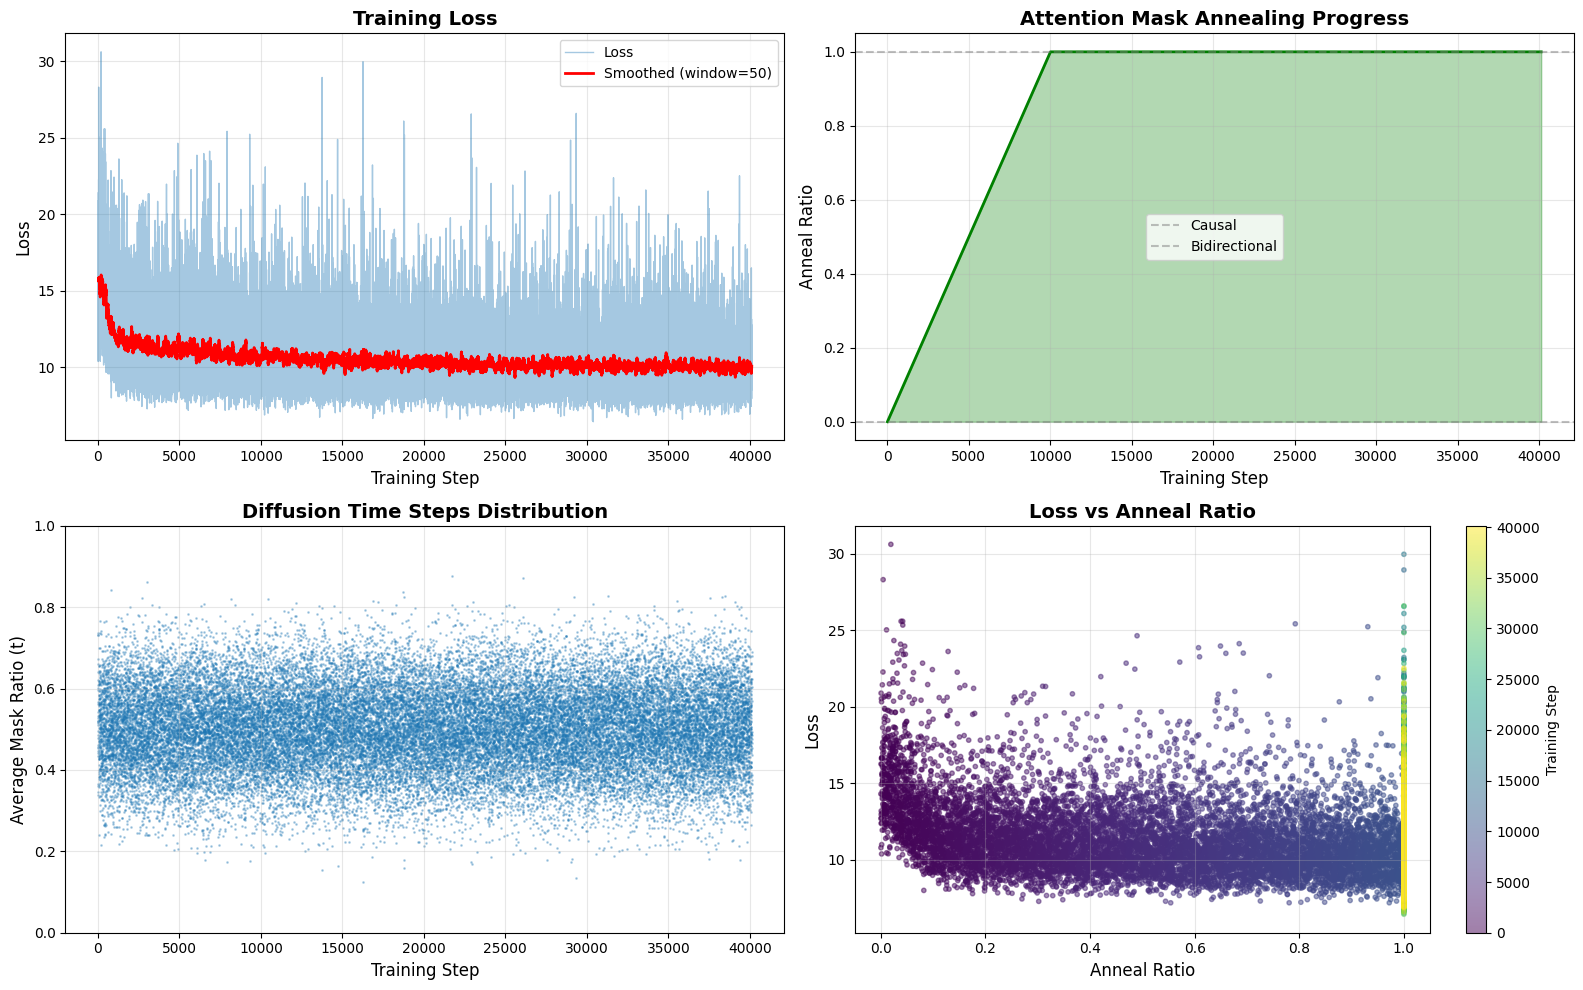

In [12]:
def plot_training_history(history, save_path=None):
    """可视化训练历史"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    steps = history['step']
    
    # 1. Loss 曲线
    ax = axes[0, 0]
    ax.plot(steps, history['loss'], alpha=0.4, label='Loss', linewidth=1)
    # 平滑
    window = min(50, len(history['loss']) // 10)
    if window > 1:
        smoothed = np.convolve(
            history['loss'],
            np.ones(window)/window,
            mode='valid'
        )
        ax.plot(
            steps[window-1:],
            smoothed,
            'r-',
            linewidth=2,
            label=f'Smoothed (window={window})'
        )
    ax.set_xlabel('Training Step', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Anneal Ratio 进度
    ax = axes[0, 1]
    ax.plot(steps, history['anneal_ratio'], 'g-', linewidth=2)
    ax.fill_between(steps, 0, history['anneal_ratio'], alpha=0.3, color='green')
    ax.set_xlabel('Training Step', fontsize=12)
    ax.set_ylabel('Anneal Ratio', fontsize=12)
    ax.set_title('Attention Mask Annealing Progress', fontsize=14, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(y=0.0, color='gray', linestyle='--', alpha=0.5, label='Causal')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Bidirectional')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. 平均 Mask Ratio
    ax = axes[1, 0]
    ax.scatter(steps, history['avg_mask_ratio'], alpha=0.3, s=1)
    ax.set_xlabel('Training Step', fontsize=12)
    ax.set_ylabel('Average Mask Ratio (t)', fontsize=12)
    ax.set_title('Diffusion Time Steps Distribution', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # 4. Loss vs Anneal Ratio
    ax = axes[1, 1]
    scatter = ax.scatter(
        history['anneal_ratio'],
        history['loss'],
        c=steps,
        cmap='viridis',
        alpha=0.5,
        s=10
    )
    ax.set_xlabel('Anneal Ratio', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Loss vs Anneal Ratio', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Training Step')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ 训练历史图保存到: {save_path}")
    
    plt.show()


# 绘制训练历史
plot_training_history(
    history,
    save_path=os.path.join(config.output_dir, 'training_history.png')
)

## 1️⃣3️⃣ 保存模型

In [13]:
# 保存模型
model_save_path = os.path.join(config.output_dir, 'final_model')
os.makedirs(model_save_path, exist_ok=True)

print(f"\n保存模型到: {model_save_path}")

# 保存 GPT2 基础模型
model.gpt2.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# 保存训练历史
history_path = os.path.join(config.output_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

# 保存配置
config_path = os.path.join(config.output_dir, 'training_config.json')
with open(config_path, 'w') as f:
    json.dump(vars(config), f, indent=2)

print(f"✓ 模型保存完成!")
print(f"  - 模型: {model_save_path}")
print(f"  - 训练历史: {history_path}")
print(f"  - 配置: {config_path}")


保存模型到: ./outputs/gpt2_diffusion_full/final_model
✓ 模型保存完成!
  - 模型: ./outputs/gpt2_diffusion_full/final_model
  - 训练历史: ./outputs/gpt2_diffusion_full/training_history.json
  - 配置: ./outputs/gpt2_diffusion_full/training_config.json


## 1️⃣4️⃣ 生成测试


################################################################################
🚀 文本生成对比: Autoregressive vs Diffusion
################################################################################


📝 Prompt: The future of artificial intelligence

🔹 Method 1: Autoregressive Generation (传统方式)
--------------------------------------------------------------------------------

✅ Result: The future of artificial intelligence is one of the leading topics in the field today. today a wide range of exciting topics in machine learning and specific activity building tools to use to tackle the specific settings, customizable

🔹 Method 2: Diffusion Generation (Paper Algorithm 2)
--------------------------------------------------------------------------------

🌱 Diffusion 生成 (Algorithm 2 from Paper)

📝 Prompt: The future of artificial intelligence
🎯 序列长度: 40 | 迭代步数: 16


━━ Step 1/16 (t=16) ━━
  📊 Alpha_t: 0.000 | Alpha_s: 0.062
  🎭 Transition prob: 0.062
  🎯 Masked tokens: 35/40
  📝 Text: [M]The

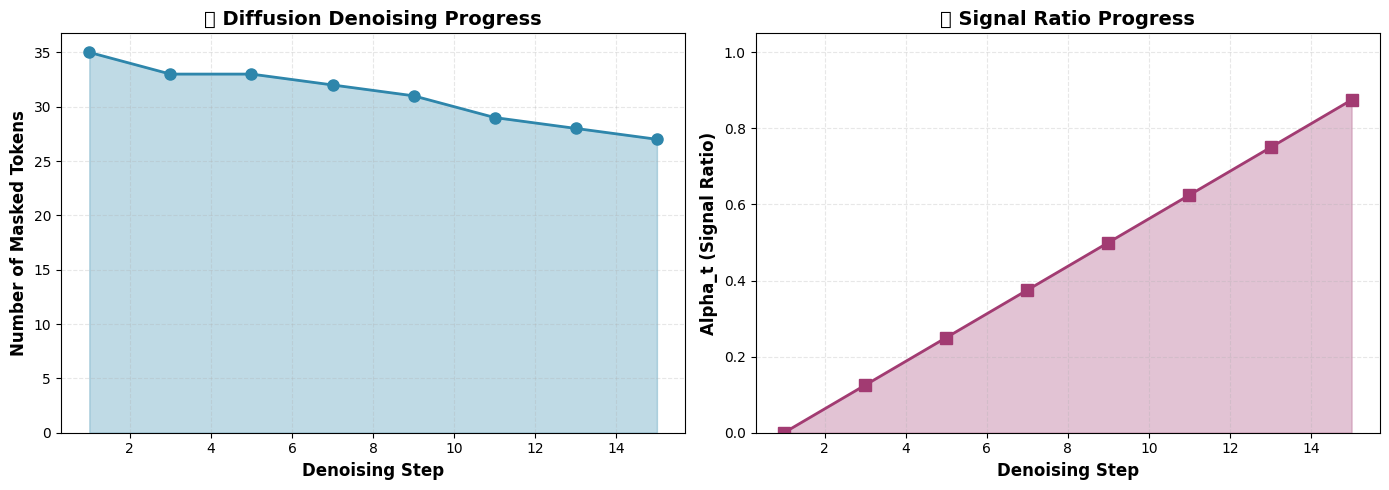



📝 Prompt: Once upon a time

🔹 Method 1: Autoregressive Generation (传统方式)
--------------------------------------------------------------------------------

✅ Result: Once upon a time. the human is governed and it depends on the system. while in fact our own spin is controlled by a system, when a system is in an external system. for a better

🔹 Method 2: Diffusion Generation (Paper Algorithm 2)
--------------------------------------------------------------------------------

🌱 Diffusion 生成 (Algorithm 2 from Paper)

📝 Prompt: Once upon a time
🎯 序列长度: 40 | 迭代步数: 16


━━ Step 1/16 (t=16) ━━
  📊 Alpha_t: 0.000 | Alpha_s: 0.062
  🎭 Transition prob: 0.062
  🎯 Masked tokens: 36/40
  📝 Text: [M]Once upon a time[M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M][M...

━━ Step 3/16 (t=14) ━━
  📊 Alpha_t: 0.125 | Alpha_s: 0.188
  🎭 Transition prob: 0.071
  🎯 Masked tokens: 35/40
  📝 Text: [M] a[M]Once upon a time[M][M][M][M][M][M][M][M][M][M][M][M][

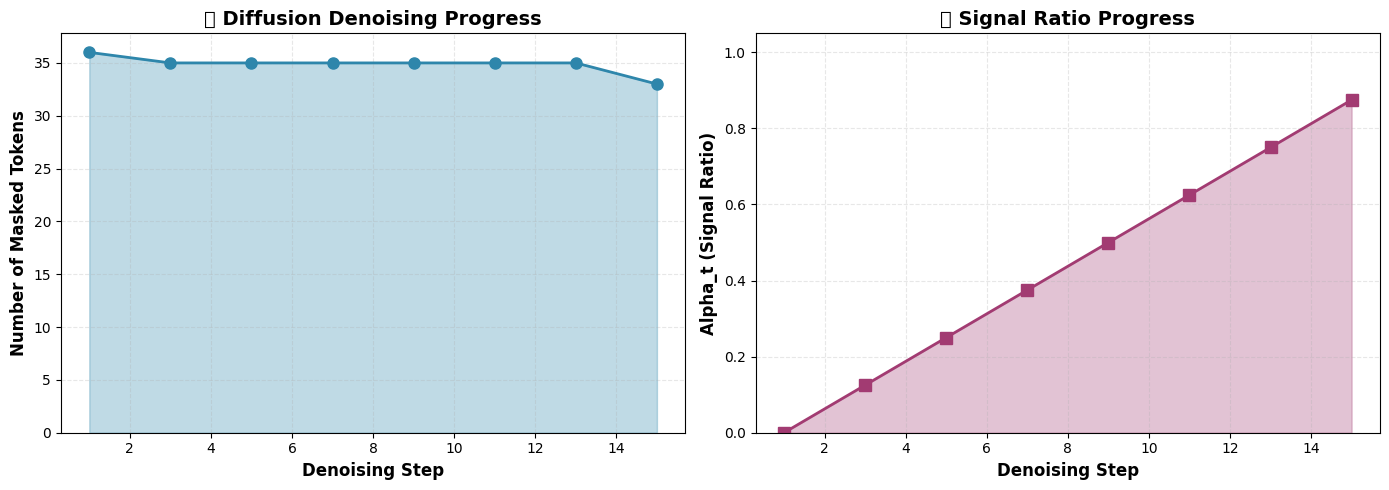

In [14]:
def generate_autoregressive(
    model,
    tokenizer,
    prompt,
    max_length=50,
    temperature=0.8,
    anneal_ratio=0.0
):
    """
    Autoregressive 生成（传统方式）
    """
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(config.device)
    
    with torch.no_grad():
        for step in range(max_length - input_ids.shape[1]):
            logits = model(input_ids=input_ids, anneal_ratio=anneal_ratio)
            next_token_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            
            if next_token[0].item() == tokenizer.eos_token_id:
                break
    
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)


def generate_diffusion_paper(
    model,
    tokenizer,
    prompt="",
    seq_length=50,
    num_steps=32,
    temperature=0.8,
    visualize=True
):
    """
    根据论文 Algorithm 2 实现的 Diffusion 生成
    
    论文核心算法：
    1. Initialize x_T = [MASK, MASK, ..., MASK]
    2. for t = T, ..., 1 do
    3.   logits ← f_θ(x_t)
    4.   Sample x̃_0 ~ Categorical(τ(logits))
    5.   for n = 1, ..., N do
    6.     x_{t-1}^n = q(x_{t-1}|x_t^n, x̃_0^n)  # Backward transition
    7.   end for
    8.   Right shift: x_{t-1} = [start_token, x_{t-1}^{1:N-1}]
    9. end for
    10. Return x_0^{2:N}
    
    Backward transition (Eq.4):
      q(x_s|x_t, x_0) = {
        (alpha_s - alpha_t)/(1 - alpha_t) * x_0 + (1 - alpha_s)/(1 - alpha_t) * m,  if x_t = m
        x_0,  if x_t ≠ m
      }
    """
    model.eval()
    
    # 定义 mask token
    mask_token_id = tokenizer.unk_token_id if tokenizer.unk_token_id is not None else tokenizer.pad_token_id
    start_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
    
    # 处理 prompt
    if prompt:
        prompt_ids = tokenizer.encode(prompt, return_tensors='pt', add_special_tokens=False).to(config.device)
        prompt_len = prompt_ids.shape[1]
        # 初始化：prompt + mask tokens
        x_t = torch.cat([
            prompt_ids,
            torch.full((1, seq_length - prompt_len), mask_token_id, device=config.device, dtype=torch.long)
        ], dim=1)
    else:
        # 初始化：全部是 mask tokens (Algorithm 2, line 1)
        x_t = torch.full((1, seq_length), mask_token_id, device=config.device, dtype=torch.long)
        prompt_len = 0
    
    # 设置 noise schedule: alpha_t = 1 - t
    def get_alpha(t, T):
        return 1 - t / T
    
    if visualize:
        print(f"\n{'='*80}")
        print(f"🌱 Diffusion 生成 (Algorithm 2 from Paper)")
        print(f"{'='*80}\n")
        if prompt:
            print(f"📝 Prompt: {prompt}")
        print(f"🎯 序列长度: {seq_length} | 迭代步数: {num_steps}\n")
    
    history = []
    
    with torch.no_grad():
        # 迭代 T 步 (Algorithm 2, line 2)
        for step in range(num_steps, 0, -1):  # T, T-1, ..., 1
            t = step
            s = step - 1  # 下一个时间步
            
            alpha_t = get_alpha(t, num_steps)
            alpha_s = get_alpha(s, num_steps) if s > 0 else 1.0
            
            # Forward pass (Algorithm 2, line 3)
            logits = model(input_ids=x_t, anneal_ratio=1.0)  # 使用全双向注意力
            
            # Sample x̃_0 from categorical distribution (Algorithm 2, line 4)
            probs = F.softmax(logits / temperature, dim=-1)
            x_0_pred = torch.multinomial(
                probs.view(-1, probs.shape[-1]), 
                num_samples=1
            ).view(1, -1)
            
            # Backward transition for each token (Algorithm 2, lines 5-7)
            x_s = torch.zeros_like(x_t)
            
            for n in range(seq_length):
                # Backward transition (Eq.4)
                if x_t[0, n] == mask_token_id:
                    # 如果当前是 mask，按概率跳转到预测的 x_0 或保持 mask
                    prob_to_x0 = (alpha_s - alpha_t) / (1 - alpha_t) if alpha_t < 1.0 else 0.0
                    
                    if np.random.rand() < prob_to_x0:
                        x_s[0, n] = x_0_pred[0, n]
                    else:
                        x_s[0, n] = mask_token_id
                else:
                    # 如果不是 mask，保持原值
                    x_s[0, n] = x_t[0, n]
            
            # Right shift operation (Algorithm 2, line 8)
            # 这是论文的关键操作！
            x_s_shifted = torch.cat([
                torch.tensor([[start_token_id]], device=config.device, dtype=torch.long),
                x_s[:, :-1]
            ], dim=1)
            
            x_t = x_s_shifted
            
            # 记录历史
            if visualize and step % max(1, num_steps // 8) == 0:
                num_masked = (x_t == mask_token_id).sum().item()
                text = tokenizer.decode(x_t[0], skip_special_tokens=False)
                text = text.replace(tokenizer.unk_token, '[M]').replace(tokenizer.pad_token, '[M]')
                
                print(f"\n━━ Step {num_steps - step + 1}/{num_steps} (t={step}) ━━")
                print(f"  📊 Alpha_t: {alpha_t:.3f} | Alpha_s: {alpha_s:.3f}")
                print(f"  🎭 Transition prob: {(alpha_s - alpha_t) / (1 - alpha_t) if alpha_t < 1.0 else 0:.3f}")
                print(f"  🎯 Masked tokens: {num_masked}/{seq_length}")
                print(f"  📝 Text: {text[:120]}...")
                
                history.append({
                    'step': num_steps - step + 1,
                    'alpha_t': alpha_t,
                    'num_masked': num_masked,
                    'text': text
                })
    
    # Return x_0^{2:N} (Algorithm 2, line 10)
    # 由于 shift操作，需要跳过第一个 token
    final_tokens = x_t[:, 1:]
    final_text = tokenizer.decode(final_tokens[0], skip_special_tokens=True)
    
    if visualize:
        print(f"\n{'='*80}")
        print(f"✅ 生成完成!")
        print(f"{'='*80}")
        print(f"\n🎉 最终文本:\n{final_text}")
        print(f"\n{'='*80}\n")
    
    return final_text, history


def visualize_diffusion_process(history, save_path=None):
    """可视化 diffusion 生成过程"""
    if not history:
        return
        
    steps = [h['step'] for h in history]
    num_masked = [h['num_masked'] for h in history]
    alpha_t = [h['alpha_t'] for h in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 去噪进度
    ax1.plot(steps, num_masked, marker='o', linewidth=2, markersize=8, color='#2E86AB')
    ax1.fill_between(steps, num_masked, alpha=0.3, color='#2E86AB')
    ax1.set_xlabel('Denoising Step', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Masked Tokens', fontsize=12, fontweight='bold')
    ax1.set_title('🔄 Diffusion Denoising Progress', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(bottom=0)
    
    # Alpha_t 进度
    ax2.plot(steps, alpha_t, marker='s', linewidth=2, markersize=8, color='#A23B72')
    ax2.fill_between(steps, alpha_t, alpha=0.3, color='#A23B72')
    ax2.set_xlabel('Denoising Step', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Alpha_t (Signal Ratio)', fontsize=12, fontweight='bold')
    ax2.set_title('🎯 Signal Ratio Progress', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim([0, 1.05])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ 可视化图表已保存: {save_path}")
    
    plt.show()


# 测试生成
test_prompts = [
    "The future of artificial intelligence",
    "Once upon a time",
]

print("\n" + "#"*80)
print("🚀 文本生成对比: Autoregressive vs Diffusion")
print("#"*80)

for prompt in test_prompts:
    print(f"\n\n{'='*80}")
    print(f"📝 Prompt: {prompt}")
    print(f"{'='*80}\n")
    
    # 1. Autoregressive 生成
    print("🔹 Method 1: Autoregressive Generation (传统方式)")
    print("-" * 80)
    ar_text = generate_autoregressive(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_length=40,
        temperature=0.8,
        anneal_ratio=0.0
    )
    print(f"\n✅ Result: {ar_text}\n")
    
    # 2. Diffusion 生成（论文方法）
    print("🔹 Method 2: Diffusion Generation (Paper Algorithm 2)")
    print("-" * 80)
    diff_text, history = generate_diffusion_paper(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        seq_length=40,
        num_steps=16,
        temperature=0.8,
        visualize=True
    )
    
    # 可视化 diffusion 过程
    visualize_diffusion_process(
        history,
        save_path=os.path.join(config.output_dir, f'diffusion_process_{test_prompts.index(prompt)}.png')
    )

## 1️⃣5️⃣ 总结

### 🎯 实现的功能：

1. **Attention Mask Annealing**
   - ✅ 从因果掩码（只能看左边）逐渐过渡到双向注意力（可以看全部）
   - ✅ 训练过程中动态调整注意力范围
   - ✅ 可视化不同退火阶段的注意力模式

2. **Shift Operation**
   - ✅ 在计算 loss 时对 target 进行位移
   - ✅ 预测下一个 token 而不是当前 token
   - ✅ 论文验证的有效技术

3. **Diffusion 训练**
   - ✅ 随机 mask 输入序列
   - ✅ 时间步加权的 loss
   - ✅ 完整的训练流程

4. **可视化和监控**
   - ✅ 训练 loss 曲线
   - ✅ Anneal ratio 进度
   - ✅ Mask ratio 分布
   - ✅ Loss vs Anneal ratio 关系

### 📊 关键创新点：

- 同时使用 **Attention Annealing** 和 **Shift Operation**
- 将 GPT2 从 autoregressive 平滑过渡到 diffusion
- 保留预训练权重，提升训练效率

### 🚀 下一步：

1. 使用更大的数据集和更长的训练时间
2. 尝试不同的 annealing schedule
3. 对比有/无 shift operation 的效果
4. 实现完整的 diffusion 采样过程

---

**参考论文**: *Scaling Diffusion Language Models via Adaptation from Autoregressive Models* (ICLR 2025)